# Run parcel tracking with tracer

In [1]:
import numpy as np
from datetime import timedelta as delta, datetime
import xarray as xr
from parcels import FieldSet, Variable, ParticleSet, JITParticle, AdvectionRK4_3D, ErrorCode
import glob
import matplotlib.pyplot as plt

%matplotlib inline

#### Parameters

In [2]:
year = 2002

# Sub-domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

#### General setup

Timestamps:

In [3]:
# Mesh mask
mesh_mask = '/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc'

# Lists of ANHA12 NEMO U,V,W files (on full ANHA12 domain)
folder_ANHA12      = '/data/brogalla/ANHA12/'
ANHA12_gridU_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year}m??d??_gridU.nc'))[0:20]
ANHA12_gridV_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_y{year}m??d??_gridV.nc'))[0:20]
ANHA12_gridW_files = sorted(glob.glob(f'{folder_ANHA12}ANHA12-EXH006_5d_gridW_y{year}m??d??.nc'))[0:20]

# Lists of ANHA12 NEMO Pb tracer files (on sub-domain of full ANHA12 domain)
folder_Pb = f'/data/brogalla/run_storage/Pb-new-ini2-20220922/'
files_Pb  = sorted(glob.glob(f'{folder_Pb}ANHA12_EXH006_5d_{year}0101_{year}1231_ptrc_T_{year}*'))[0:20]

# Create timestamps from file dates: (because of time_origin issue in ANHA12 netcdf dynamics files)
time_stamps_files = []
for n, file in enumerate(ANHA12_gridU_files):
    dateU  = datetime.strptime(file[36:47],'y%Ym%md%d')
    dateV  = datetime.strptime(ANHA12_gridV_files[n][36:47],'y%Ym%md%d')
    dateW  = datetime.strptime(ANHA12_gridW_files[n][45:56],'y%Ym%md%d')
    datePb = datetime.strptime(files_Pb[n][99:107],'%Y%m%d')
    
    # double-check that the date is the same for all files
    if (dateU != dateV) | (dateU != dateW) | (dateU != datePb):
        print('Dates not equal!')
    else:   
        time_stamps_files.append(np.datetime64(f'{dateU.year:02}-{dateU.month:02}-{dateU.day:02}'))

# array of file timestamps
timestamps_files = np.expand_dims(np.array(time_stamps_files), axis=1)

#### General functions

In [4]:
def DeleteParticle(particle, fieldset, time):
    print("Particle [%d] lost !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
    particle.delete()

In [5]:
# define new particle class for Pb
class PbParticle(JITParticle): 
    dissolvedPb = Variable('dissolpb', initial=0)  # Variable 'dissolpb' initialised by sampling the dissolved Pb field

In [6]:
def SamplePb(particle, fieldset, time):
    particle.dissolpb = fieldset.Pb[particle.time, particle.depth, particle.lat, particle.lon]

In [7]:
def run_parcels(fieldset, runtime=0, nudging=False, sampling=False):
    
    x = np.arange(-145, -30, 1)
    y = np.arange(54, 87, 1)
    plon, plat = np.meshgrid(x, y)
    pset = ParticleSet(fieldset=fieldset, pclass=PbParticle, lon=plon, lat=plat)
    
    if nudging:        
        for i in range(len(pset)):
            d = np.hypot((pset.lon[i] - fieldset.U.grid.lon), (pset.lat[i] - fieldset.U.grid.lat))
            ind = np.unravel_index(np.argmin(d, axis=None), d.shape)
            pset.xi[i, :] = ind[1]
            pset.yi[i, :] = ind[0]
    
    if sampling:
        pset.execute(AdvectionRK4_3D + pset.Kernel(SamplePb), 
                     runtime=runtime, dt=delta(hours=2), recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})        
    else:
        pset.execute(AdvectionRK4_3D, runtime=runtime, dt=delta(hours=2), recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    
    return pset

## Run with Pb as tracer (Pb on sub-domain, U,V,W on full domain) with subset indices

In [40]:
filenames  = {'U': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridU_files},
              'V': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridV_files},
              'W': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridW_files},
              'Pb': {'lon': files_Pb[0], 'lat': files_Pb[0], 'depth': files_Pb[0], 'data': files_Pb}}

dimensions = {'U': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'V': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'W': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'Pb': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'deptht'}}

variables  = {'U': 'vozocrtx',
              'V': 'vomecrty',
              'W': 'vovecrtz',
              'Pb': 'dissolpb'}

indices_subset = {'U':  {'lon': range(jmin, jmax), 'lat': range(imin, imax), 'depth': range(0,50)},
                  'V':  {'lon': range(jmin, jmax), 'lat': range(imin, imax), 'depth': range(0,50)},
                  'W':  {'lon': range(jmin, jmax), 'lat': range(imin, imax), 'depth': range(0,50)},
                  'Pb': {'lon': range(0,640)     , 'lat': range(0,1040)    , 'depth': range(0,50)}}

# needed to provide time as timestamps in order to avoid time origin type issue
fieldset   = FieldSet.from_nemo(filenames, variables, dimensions, \
                                timestamps=timestamps_files, \
                                allow_time_extrapolation=False,
                                indices=indices_subset)

Runtime=0 without nudging and no sampling:

In [ ]:
pset = run_parcels(fieldset, runtime=0, nudging=False, sampling=False)

(54.0, 87.0)

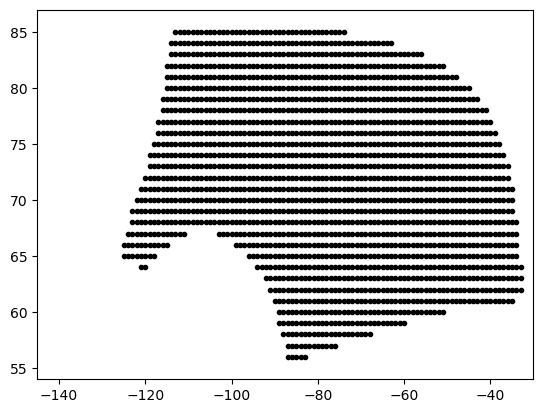

In [13]:
plt.plot(pset.lon, pset.lat, 'k.')
plt.xlim(-145,-30)
plt.ylim(54,87)

Runtime=0 with nudging and no sampling:

In [ ]:
pset = run_parcels(fieldset, runtime=0, nudging=True, sampling=False)

(54.0, 87.0)

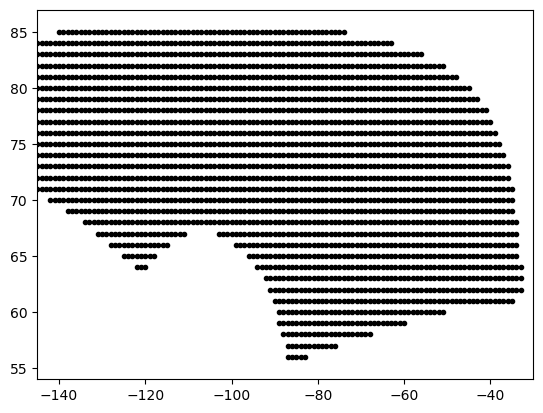

In [10]:
plt.plot(pset.lon, pset.lat, 'k.')
plt.xlim(-145,-30)
plt.ylim(54,87)

Nudging, sampling Pb, run for zero timesteps:

In [ ]:
pset = run_parcels(fieldset, runtime=0, nudging=True, sampling=True)

(54.0, 87.0)

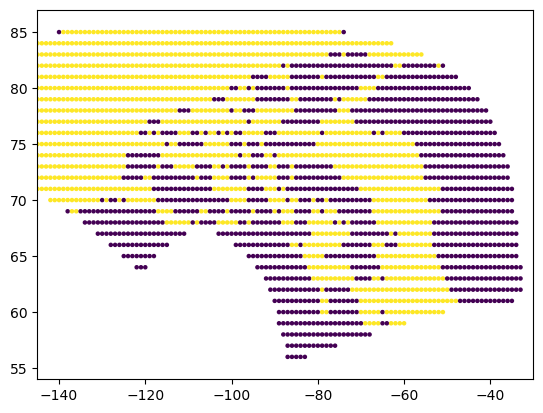

In [42]:
plt.scatter(pset.lon, pset.lat, c=pset.dissolpb, s=5, vmin=0, vmax=1e-12)
plt.xlim(-145,-30)
plt.ylim(54,87)

Subset indices, nudging, sampling Pb, run for multiple timesteps:

In [ ]:
pset = run_parcels(fieldset, runtime=delta(hours=12), nudging=True, sampling=True)

(54.0, 87.0)

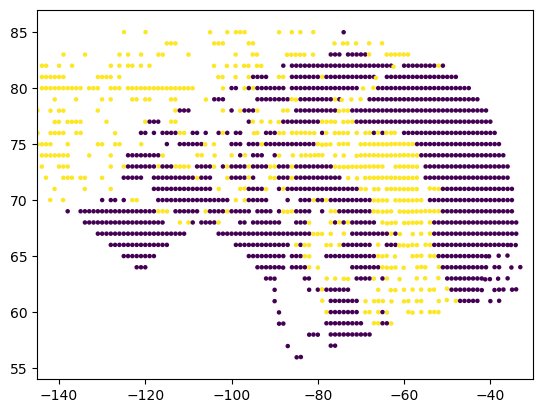

In [44]:
plt.scatter(pset.lon, pset.lat, c=pset.dissolpb, s=5, vmin=0, vmax=1e-12)
plt.xlim(-145,-30)
plt.ylim(54,87)

Output:
- Correct cell not found for (173.000000, 88.000000) after 1000000 iterations. 
    Debug info: old particle indices: (yi, xi) 0 0. 
    New particle indices: (yi, xi) 931 1630. 
    Mesh 2d shape:  2400 1632
- Correct cell not found for (-139.000000, 69.000000) after 1000000 iterations. 
    Debug info: old particle indices: (yi, xi) 1039 293. 
    New particle indices: (yi, xi) 1038 346. 
    Mesh 2d shape:  1040 640

## Run with Pb as tracer (Pb on sub-domain, U,V,W on full domain) without subset indices

In [15]:
filenames  = {'U': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridU_files},
              'V': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridV_files},
              'W': {'lon': mesh_mask   , 'lat': mesh_mask  , 'depth': ANHA12_gridW_files[0], 'data': ANHA12_gridW_files},
              'Pb': {'lon': files_Pb[0], 'lat': files_Pb[0], 'depth': files_Pb[0], 'data': files_Pb}}

dimensions = {'U': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'V': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'W': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'depthw'},
              'Pb': {'lon': 'nav_lon', 'lat': 'nav_lat', 'depth': 'deptht'}}

variables  = {'U': 'vozocrtx',
              'V': 'vomecrty',
              'W': 'vovecrtz',
              'Pb': 'dissolpb'}

# needed to provide time as timestamps in order to avoid time origin type issue
fieldset   = FieldSet.from_nemo(filenames, variables, dimensions, \
                                timestamps=timestamps_files, \
                                allow_time_extrapolation=False)

#### Runtime=0 without nudging and no sampling:

In [ ]:
pset = run_parcels(fieldset, runtime=0, nudging=False, sampling=False)

(54.0, 87.0)

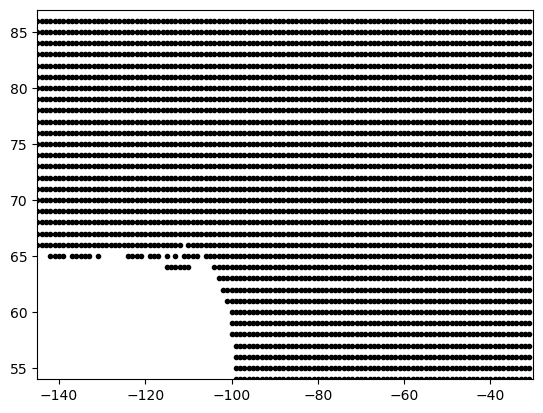

In [17]:
plt.plot(pset.lon, pset.lat, 'k.')
plt.xlim(-145,-30)
plt.ylim(54,87)

#### No nudging, no sample tracer, run for multiple timesteps:

In [ ]:
pset = run_parcels(fieldset, runtime=delta(hours=12), nudging=False, sampling=False)

(54.0, 87.0)

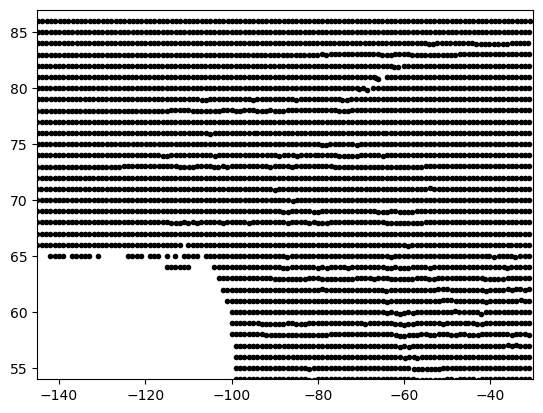

In [19]:
plt.plot(pset.lon, pset.lat, 'k.')
plt.xlim(-145,-30)
plt.ylim(54,87)

Note how even running for multiple timesteps, the particles are fine as long as the tracer isn't sampled.

#### No nudging, sample tracer, runtime=0: 

In [ ]:
pset = run_parcels(fieldset, runtime=0, nudging=False, sampling=True)

(54.0, 87.0)

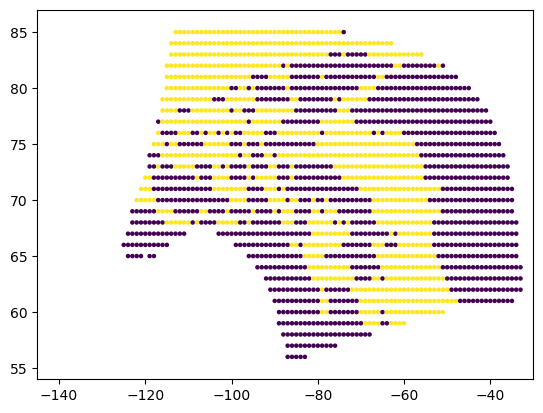

In [38]:
plt.scatter(pset.lon, pset.lat, s=5, c=pset.dissolpb, vmin=0, vmax=1e-12)
plt.xlim(-145,-30)
plt.ylim(54,87)

As soon as the tracer gets sampled, the issue appears.

#### No nudging, sample tracer, run for multiple timesteps:

In [ ]:
pset = run_parcels(fieldset, runtime=delta(hours=12), nudging=False, sampling=True)

(54.0, 87.0)

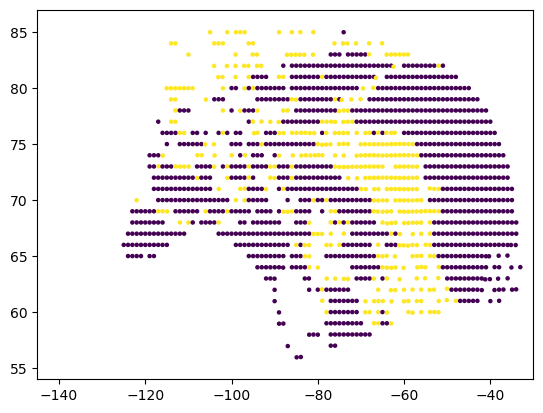

In [36]:
plt.scatter(pset.lon, pset.lat, s=5, c=pset.dissolpb, vmin=0, vmax=1e-12)
plt.xlim(-145,-30)
plt.ylim(54,87)

#### Nudging, sample tracer, runtime=0:

In [ ]:
pset = run_parcels(fieldset, runtime=0, nudging=True, sampling=True)

(54.0, 87.0)

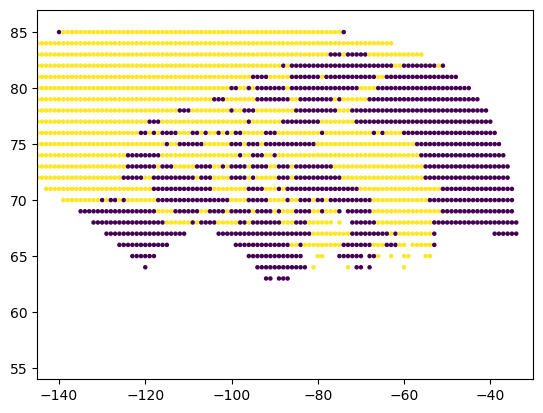

In [34]:
plt.scatter(pset.lon, pset.lat, s=5, c=pset.dissolpb, vmin=0, vmax=1e-12)
plt.xlim(-145,-30)
plt.ylim(54,87)

Note how this shifted the particles to extend far enough west, but not as far south as in the figures above.

#### Nudging, sample tracer, run for multiple timesteps:

In [ ]:
pset = run_parcels(fieldset, runtime=delta(hours=12), nudging=True, sampling=True)

(54.0, 87.0)

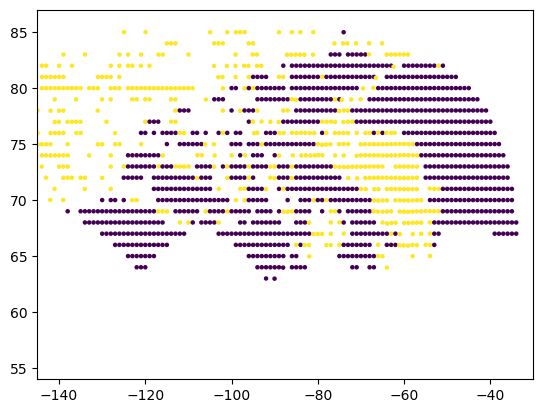

In [32]:
plt.scatter(pset.lon, pset.lat, s=5, c=pset.dissolpb, vmin=0, vmax=1e-12)
plt.xlim(-145,-30)
plt.ylim(54,87)